In [35]:
from exchange_simulator import Sim
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List, Optional, Tuple, Union, Dict
import math
from exchange_simulator import MdUpdate, Order, OwnTrade, Sim, update_best_positions


PATH_TO_FILE = 'btcusdt_Binance_LinearPerpetual/'
NROWS = 500000

In [36]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

We assuming that mid-price $S(t)$ is an Ornstein-Uhlenbeck process, i.e. 

$$dS(t)=a(\mu -S(t))dt+\sigma Wdt$$

In that case, the optimal reservation price is:

$$r_* = se^{-a(T-t)}+\mu (1-e^{-a(T-t)}) - q(2\eta + \frac{\gamma \sigma^2}{2a}(1-e^{-2a(T-t)}))$$

The optimal spread:

$$\psi_*=\frac{2}{\gamma}log(1+\frac{\gamma}{k})+2\eta+\frac{\gamma\sigma^2}{2a}(1-e^{-2a(T-t)}))$$

In [37]:
class FodraLabadie:
    def __init__(self, delta_t: float, gamma: float, trading_time: int, k: float, \
                 hold_time: float, a: float, mu: float, sigma: float, eta: float):
        """
            Args:
                delta_t(float): periodicity of trading
                hold_time: holding time in nanoseconds
                gamma(float): risk-measure
                a, mu, sigma (float): parametres of an Ornstein-Uhlenbeck process
                trading_time(int): the time during which we trade
                k(float): coeff, that we take from market data
                eta(float): inventory penalty
        """
        self.delta_t = delta_t
        self.hold_time = hold_time
        self.gamma = gamma
        self.T = trading_time
        self.k = k
        self.a = a
        self.mu = mu
        self.sigma = sigma
        self.eta = eta
        self.inventory = []

    def run(self, sim: Sim) -> \
            Tuple[List[OwnTrade], List[MdUpdate], List[Union[OwnTrade, MdUpdate]], List[Order]]:
        """
            This function runs simulation

            Args:
                sim(Sim): simulator
            Returns:
                trades_list(List[OwnTrade]): list of our executed trades
                md_list(List[MdUpdate]): list of market data received by strategy
                updates_list( List[ Union[OwnTrade, MdUpdate] ] ): list of all updates
                received by strategy(market data and information about executed trades)
                all_orders(List[Orted]): list of all placed orders
        """

        # market data list
        md_list: List[MdUpdate] = []
        # executed trades list
        trades_list: List[OwnTrade] = []
        # all updates list
        updates_list = []
        # current best positions
        best_bid = -np.inf
        best_ask = np.inf

        # last order timestamp
        prev_time = -np.inf
        # orders that have not been executed/canceled yet
        ongoing_orders: Dict[int, Order] = {}
        all_orders = []
        # position
        q = 0
        while True:
            # get update from simulator
            receive_ts, updates = sim.tick()
            if updates is None or receive_ts > self.T:
                break
            # save updates
            updates_list += updates
            for update in updates:
                # update best position
                if isinstance(update, MdUpdate):
                    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                    md_list.append(update)
                elif isinstance(update, OwnTrade):
                    trades_list.append(update)
                    # calculating change in position
                    delta_pos = 0.001 if update.side == 'BID' else -0.001
                    q += delta_pos
                    # delete executed trades from the dict
                    if update.order_id in ongoing_orders.keys():
                        ongoing_orders.pop(update.order_id)
                else:
                    assert False, 'invalid type of update!'

            if receive_ts - prev_time >= self.delta_t:
                prev_time = receive_ts
                mid_price = (best_bid + best_ask) / 2
                indif_price = (mid_price * np.exp(-self.a * (self.T - receive_ts) / self.T) + self.mu * (1 - np.exp(-self.a * (self.T - receive_ts) / self.T)) \
                              -q * (2 * self.eta + self.gamma * (self.sigma ** 2) / (2 * self.a) * (1 - np.exp(-2 * self.a * (self.T - receive_ts) / self.T))))
    
                spread = (2 / self.gamma * np.log(1 + self.gamma / self.k) + 2 * self.eta + self.gamma * (self.sigma ** 2) / (2 * self.a) \
                         * (1 - np.exp(-2 * self.a * (self.T - receive_ts) / self.T)))
                p_ask = indif_price + spread / 2
                p_bid = indif_price - spread / 2
                # place order
                bid_order = sim.place_order(receive_ts, 0.001, 'BID', p_bid)
                ask_order = sim.place_order(receive_ts, 0.001, 'ASK', p_ask)
                ongoing_orders[bid_order.order_id] = bid_order
                ongoing_orders[ask_order.order_id] = ask_order

                all_orders += [bid_order, ask_order]

            to_cancel = []
            for ID, order in ongoing_orders.items():
                if order.place_ts < receive_ts - self.hold_time:
                    sim.cancel_order(receive_ts, ID)
                    to_cancel.append(ID)
            for ID in to_cancel:
                ongoing_orders.pop(ID)
            self.inventory.append(q)

        return trades_list, md_list, updates_list, all_orders, self.inventory

In [38]:
delta_t = pd.Timedelta(0.5, 's').delta
gamma = 0.1
trading_time = 1655959437845767672
k = 100
hold_time = pd.Timedelta(10, 's').delta
a = 1
mu = 1.02
sigma = 0.05
eta = 0.0001

strategy = FodraLabadie(delta_t, gamma, trading_time, k, hold_time, a, mu, sigma, eta)

In [39]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [40]:
%time trades_list, md_list, updates_list, all_orders, inventory = strategy.run(sim)

Wall time: 40.7 s


In [41]:
%time df = get_pnl(updates_list)

Wall time: 57.9 s


In [42]:
dt = pd.to_datetime(df.receive_ts)

In [43]:
df

,receive_ts,exchange_ts,total,BTC,USD,mid_price
0,1655942402250125991,1655942402249000000,0.000000,0.000,0.000000,19977.45
1,1655942402259000000,1655942402249000000,-0.000050,-0.001,19.977400,19977.45
2,1655942402624789714,1655942402623000000,-0.000050,-0.001,19.977400,19977.45
3,1655942402657844605,1655942402655000000,-0.000050,-0.001,19.977400,19977.45
4,1655942403346968722,1655942403346000000,-0.000050,-0.001,19.977400,19977.45
...,...,...,...,...,...,...
1037642,1655959437709704577,1655959437709000000,-52.120067,-4.167,84755.705683,20352.25
1037643,1655959437747016601,1655959437746000000,-52.120067,-4.167,84755.705683,20352.25
1037644,1655959437780085139,1655959437779000000,-52.120067,-4.167,84755.705683,20352.25
1037645,1655959437812956891,1655959437812000000,-52.120067,-4.167,84755.705683,20352.25


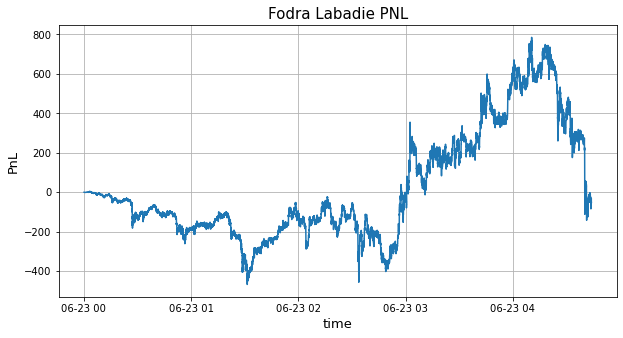

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("Fodra Labadie PNL", fontsize=15)
plt.grid()
plt.show()

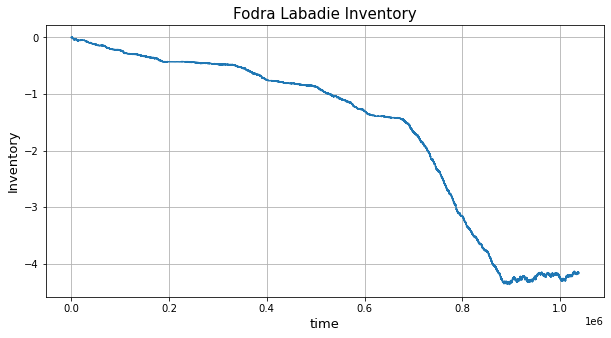

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(inventory)
plt.xlabel("time", fontsize=13)
plt.ylabel("Inventory", fontsize=13)
plt.title("Fodra Labadie Inventory", fontsize=15)
plt.grid()
plt.show()